In [1]:
import numpy as np
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import os

%matplotlib inline

data_dir = '/floyd/input'

In [2]:
def get_dataloader(batch_size=128, image_size=256):
    num_workers = 0
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.ToTensor()])
    data = datasets.ImageFolder(data_dir, transform=transform)
    
    dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    
    return dataloader

In [3]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    
img_loader = get_dataloader(128,256)
dataiter = iter(img_loader)
images,_ = dataiter.next()


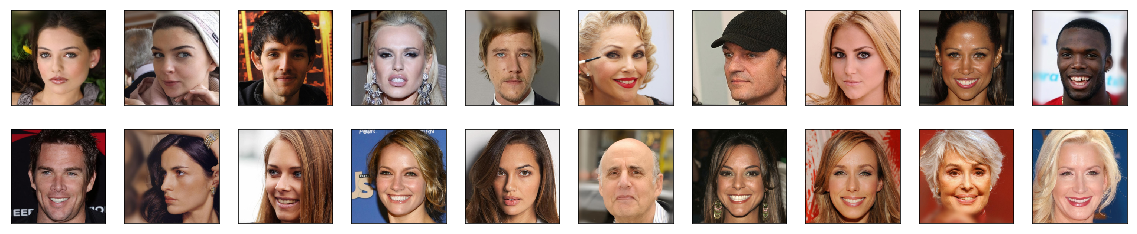

In [4]:
fig = plt.figure(figsize=(20,4))
plot_size = 20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2,plot_size/2,idx+1,xticks=[],yticks=[])
    imshow(images[idx])

In [5]:
import torch.nn as nn 
import torch.nn.functional as F
import torch
from torch.nn.modules.utils import _pair
import numpy as np

class PixelNorm(nn.Module):
    def __init__(self):
        super(PixelNorm,self).__init__()
        
    def forward(self, x, epsilon=1e-08):
        y = x.pow(2.).mean(dim=1,keepdim=True).add(epsilon).sqrt()
        y = x/y
        return y
    

In [6]:
class Equalized_conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, k_size, stride=1, padding=0):
        super(Equalized_conv2d,self).__init__()
        
        self.stride = stride
        self.padding = padding    
        
        self.weight = nn.Parameter(nn.init.normal_(torch.empty(out_channels,in_channels, *_pair(k_size))))
        
        scl_in = np.prod(_pair(k_size)) * in_channels
        self.scale = np.sqrt(2) / np.sqrt(scl_in)
    def forward(self,x):
        return F.conv2d(input=x,
                        weight=self.weight * self.scale,
                        stride=self.stride,
                        padding=self.padding)

In [7]:
class Equalized_deconv2d(nn.Module):
    def __init__(self, in_channels, out_channels, k_size, stride=1, padding=0):
        super(Equalized_deconv2d,self).__init__()
        
        self.stride = stride
        self.pad = padding
        
        self.weight = nn.Parameter(nn.init.normal_(torch.empty(in_channels,out_channels,*_pair(k_size))))
        
        scl_in = in_channels
        self.scale = np.sqrt(2) / np.sqrt(scl_in)
    def forward(self,x):
        return F.conv_transpose2d(input=x,
                                  weight=self.weight * self.scale,
                                  stride=self.stride,
                                  padding=self.pad)

In [8]:
class GenInitialBlock(nn.Module):
    def __init__(self, in_channels):
        super(GenInitialBlock,self).__init__()
        
        self.conv1 = Equalized_deconv2d(in_channels, in_channels, 4)
        self.conv2 = Equalized_conv2d(in_channels, in_channels,3, padding=1)
        
        self.pixNorm = PixelNorm()
        self.lRelu = nn.LeakyReLU(0.2)
    def forward(self, x):
        
        y = torch.unsqueeze(torch.unsqueeze(x,-1),-1)
        
        y = self.lRelu(self.conv1(y))
        y = self.lRelu(self.conv2(y))
        y = self.pixNorm(y)
        
        return y
        
        

In [9]:
class GenConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GenConvBlock,self).__init__()
        
        self.upsample = lambda x: F.interpolate(x,scale_factor=2)
        
        self.conv1 = Equalized_conv2d(in_channels, out_channels,3,padding=1)
        self.conv2 = Equalized_conv2d(out_channels, out_channels,3,padding=1)
        self.pixNorm = PixelNorm()
        self.lRelu = nn.LeakyReLU(0.2)
        
    def forward(self,x):
        y = self.upsample(x)
        y = self.pixNorm(self.lRelu(self.conv1(y)))
        y = self.pixNorm(self.lRelu(self.conv2(y)))
        
        return y

In [10]:
class Generator(nn.Module):
    def __init__(self, depth=7, latent_size=512):
        super(Generator,self).__init__()
        
        self.depth = depth
        self.latent_size = latent_size
        
        self.initial_block = GenInitialBlock(self.latent_size)
        
        self.layers = nn.ModuleList([])
        
        self.toRGB = lambda in_channels: Equalized_conv2d(in_channels,3,(1,1))
        self.RGBmodules = nn.ModuleList([self.toRGB(self.latent_size)])
        
        for i in range(self.depth - 1):
            if i<=2:
                layer = GenConvBlock(self.latent_size, 
                                     self.latent_size)
                rgb  = self.toRGB(self.latent_size)
            else:
                layer = GenConvBlock(int(self.latent_size // np.power(2,i - 3)), 
                                     int(self.latent_size // np.power(2,i - 2)))
                rgb = self.toRGB(int(self.latent_size // np.power(2,i - 2)))
                
            self.layers.append(layer)
            self.RGBmodules.append(rgb)
            
        self.temporaryUpsampler = lambda x: F.interpolate(x, scale_factor=2)
    
    def forward(self,x,depth,alpha):
        
        assert depth < self.depth, "Requested output depth cannot be produced"
        
        y = self.initial_block(x)
        
        if depth>0:
        
            for block in self.layers[:depth-1]:
                y = block(y)

            cross = self.RGBmodules[depth - 1](self.temporaryUpsampler(y))
            straight = self.RGBmodules[depth](self.layers[depth - 1](y))

            out = (alpha * straight) +((1 - alpha) * cross)
        else:
            out = self.RGBmodules[0](y)
            
        return out
        

In [11]:
class DisFinalBlock(nn.Module):
    def __init__(self,in_channels):
        
        super(DisFinalBlock, self).__init__()
        
        self.conv1 = Equalized_conv2d(in_channels, in_channels,(3,3),padding=1)
        self.conv2 = Equalized_conv2d(in_channels, in_channels,(4,4))
        self.conv3 = Equalized_conv2d(in_channels, 1,(1,1))
        
        self.lRelu = nn.LeakyReLU(0.2)
        
    def forward(self,x):
        y = self.lRelu(self.conv1(x))
        y = self.lRelu(self.conv2(y))
        y = self.conv3(y)
        
        y = y.view(-1)
        
        return y

In [12]:
class DisConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DisConvBlock,self).__init__()
        
        self.conv1 = Equalized_conv2d(in_channels, in_channels,(3,3),padding=1)
        self.conv2 = Equalized_conv2d(in_channels, out_channels,(3,3),padding=1)
        
        self.downsampler = nn.AvgPool2d(2)
        self.lRelu = nn.LeakyReLU(0.2)
        
    def forward(self,x):
        y = self.lRelu(self.conv1(x))
        y = self.lRelu(self.conv2(y))
        y = self.downsampler(y)
        
        return y

In [13]:
class Discriminator(nn.Module):
    def __init__(self, length=7, feature_size=512):
        super(Discriminator,self).__init__()
        
        self.length = length
        self.feature_size = feature_size
        
        self.final_block = DisFinalBlock(self.feature_size)
        
        self.layers = nn.ModuleList([])
        self.fromRGB = lambda out_channels: Equalized_conv2d(3,out_channels,(1,1))
        
        self.RGBfeatures = nn.ModuleList([self.fromRGB(self.feature_size)])
        
        for i in range(self.length-1):
            if i<=2:
                layer = DisConvBlock(self.feature_size,
                                     self.feature_size)
                rgb = self.fromRGB(self.feature_size)
            else:
                layer = DisConvBlock(int(self.feature_size // np.power(2,i-2)),
                                     int(self.feature_size // np.power(2,i-3)))
                rgb = self.fromRGB(int(self.feature_size // np.power(2,i-2)))
                
            self.layers.append(layer)
            self.RGBfeatures.append(rgb)
            
        self.temporaryDownSampler = nn.AvgPool2d(2)
    def forward(self,x,length,alpha):
            if length > 0:
                cross = self.RGBfeatures[length-1](self.temporaryDownSampler(x))
                straight = self.layers[length-1](self.RGBfeatures[length](x))

                y = (alpha * straight) + ((1-alpha) * cross)

                for block in reversed(self.layers[:length-1]):
                    y = block(y)
            else:
                y = self.RGBfeatures[0](x)
                
            y = self.final_block(y)
            
            return y 
                
            

In [14]:
train_on_gpu = torch.cuda.is_available()

In [15]:
torch.cuda.device_count()

1

In [16]:
latent_size = 512
depth = 7
learning_rate = 0.001
beta1 = 0
beta2 = 0.99
eps = 1e-8

G = Generator(depth, latent_size)
D = Discriminator(depth, latent_size)

g_optimizer = torch.optim.Adam(G.parameters(),learning_rate,betas=(beta1,beta2),eps=eps)
d_optimizer = torch.optim.Adam(D.parameters(),learning_rate,betas=(beta1,beta2),eps=eps)


In [17]:
def progressive_downsampling(batch,depth,alpha):
    total_depth = 7   #total depth of layers as specified in paper
    
    downsample_factor = int(np.power(2,total_depth - depth - 1))
    prior_downsample_factor = max(int(np.power(2,total_depth - depth)),0)
    
    ds_real_samples = nn.AvgPool2d(downsample_factor)(batch)
    
    if depth>0:
        prior_real_samples = F.interpolate(nn.AvgPool2d(prior_downsample_factor)(batch),
                                           scale_factor=2)
    else:
        prior_real_samples = ds_real_samples
        
    real_samples = (alpha * ds_real_samples) + ((1 - alpha) * prior_real_samples)
    
    return real_samples

In [18]:
def discriminator_loss_wgan(real_samples, fake_samples, depth, alpha):
    drift_factor = 0.001 # mentioned in the paper
    fake_out = D(fake_samples, depth, alpha)
    real_out = D(real_samples, depth, alpha)
    assert not np.any(np.isnan(real_out.cpu().detach().numpy())), "real_out contains nan's"
    assert not np.any(np.isnan(fake_out.cpu().detach().numpy())), "fake_out contains nan's"
    
    
    loss = (torch.mean(fake_out) - torch.mean(real_out) + (drift_factor * torch.mean(real_out ** 2)))
    
    return loss

In [19]:
def generator_loss_wgan(fake_samples, depth, alpha):
    fake_out = D(fake_samples, depth, alpha)
    print(fake_out.size())
    loss = -torch.mean(fake_out)
    
    return loss

In [20]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [21]:
def discriminator_loss(real_samples, fake_samples, depth, alpha):
    fake_out = D(fake_samples, depth, alpha)
    real_out = D(real_samples, depth, alpha)
    
    d_fake_loss = fake_loss(fake_out)
    d_real_loss = real_loss(real_out)
    
    loss = d_fake_loss + d_real_loss
    
    return loss

def generator_loss(fake_samples, depth, alpha):
    fake_out = D(fake_samples, depth, alpha)
    loss = real_loss(fake_out)
    
    return loss
    

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

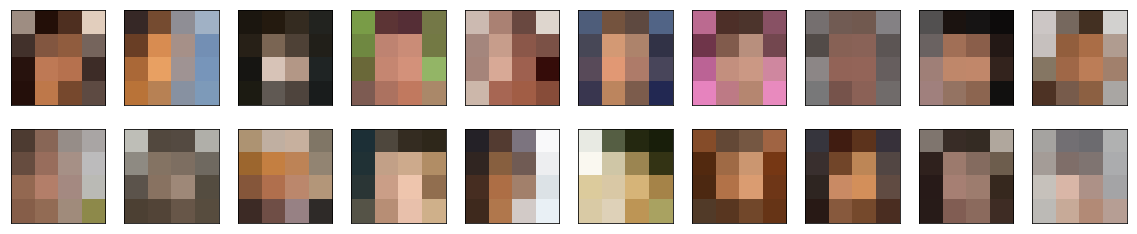

In [22]:
images,_ = dataiter.next()
real_samples = progressive_downsampling(images,0,0.5)

fig = plt.figure(figsize=(20,4))
plot_size = 20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2,plot_size/2,idx+1,xticks=[],yticks=[])
    imshow(real_samples[idx])

In [23]:
real_samples[2].size()

torch.Size([3, 4, 4])

In [26]:
fake_samples[2].size()

torch.Size([3, 4, 4])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

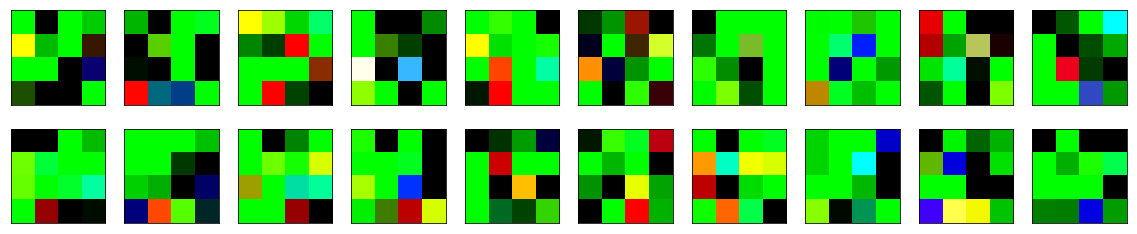

In [25]:
z = np.random.uniform(-1,1,size = (128,512))
gan_input = torch.from_numpy(z).float()
#print(np.any(np.isnan(gan_input.numpy())))
fake_samples = G(gan_input,0,0.5).detach()
#print(np.any(np.isnan(fake_samples.detach().numpy())))
fig = plt.figure(figsize=(20,4))
plot_size = 20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2,plot_size/2,idx+1,xticks=[],yticks=[])
    imshow(fake_samples[idx])


In [34]:
d_loss = discriminator_loss(real_samples, fake_samples, 0, 0.000425531914893617)

In [35]:
d_loss

tensor(1.3156, grad_fn=<ThAddBackward>)

In [25]:
from torchvision.utils import save_image

def train(D, G, num_epochs=5, batch_size=10, latent_size=512, 
          fade_percent=50, start_depth=1, feedback_factor=500,
          checkpoint_factor=1):
    total_depth = 7 #as mentioned in paper
    D.to(device)
    G.to(device)
    D.train()
    G.train()
    
    sample_dir = "./samples/"
    save_dir = "./models/"
    
    losses = []
    
    sample_size=16
    fixed_input = torch.randn(sample_size, latent_size).to(device)
    
    print("starting the training process")
    for current_depth in range(start_depth,total_depth):
        print(f'currently working on depth {current_depth}')
        current_res = int(np.power(2,current_depth+2))
        print(f'current resolution is {current_res}')
        
        ticker=1
        data = get_dataloader(batch_size=batch_size)
        print(len(iter(data)))
        
        for epoch in range(1, num_epochs+1):
            
            total_batches = len(iter(data))
            fader_point = int((fade_percent / 100) * num_epochs * total_batches)
            
            step = 0
            
            for batch_i, (real_images,_) in enumerate(data):
                real_images = real_images.to(device)
                
                alpha = ticker / fader_point if ticker <= fader_point else 1
                
                batch_size = real_images.shape[0]
                gan_input = torch.randn(batch_size, latent_size).to(device)
                
                
                fake_samples = G(gan_input,current_depth,alpha)
                real_samples = progressive_downsampling(real_images,current_depth,alpha)
                
                d_loss = discriminator_loss(real_samples, fake_samples, current_depth, alpha)
                d_optimizer.zero_grad()
                d_loss.backward()
                d_optimizer.step()
                del real_samples, fake_samples, real_images
                torch.cuda.empty_cache()
                
                fake_samples = G(gan_input,current_depth,alpha)
                
                g_loss = generator_loss(fake_samples, current_depth, alpha)
                g_optimizer.zero_grad()
                g_loss.backward()
                g_optimizer.step()
                del fake_samples, gan_input
                torch.cuda.empty_cache()
                
                if batch_i % feedback_factor == 0:
                    print(f'epoch: {epoch}, discriminator loss: {d_loss.item()}, generator loss: {g_loss.item()}')
                    losses.append((d_loss.item(), g_loss.item()))
                    os.makedirs(sample_dir,exist_ok=True)
                    gen_img_file = os.path.join(sample_dir + "gen_" + str(current_depth) + 
                                                '_' + str(epoch) + '_' + str(batch_i) + '.png')
                    
                    with torch.no_grad():
                        G.eval()
                        samples = G(fixed_input, current_depth, alpha)
                        samples = F.interpolate(samples,scale_factor = int(np.power(2, total_depth - current_depth - 1)))
                        save_image(samples, gen_img_file, nrow=int(np.sqrt(len(samples))),
                                   normalize=True, scale_each=True)
                        del samples
                        torch.cuda.empty_cache()
                        G.train()
                ticker += 1
                step += 1
            torch.cuda.empty_cache()
            
            os.makedirs(save_dir, exist_ok=True)
            gen_save_file = os.path.join(save_dir + 'gen_' + str(current_depth) + '.pth')
            dis_save_file = os.path.join(save_dir + 'dis_' + str(current_depth) + '.pth')
            
            torch.save(G.state_dict(), gen_save_file)
            torch.save(D.state_dict(), dis_save_file)
        del data
        torch.cuda.empty_cache()
    
    print('training completed')
            
    return losses             
                    
    

In [24]:
torch.cuda.empty_cache()

In [ ]:

losses = train(D,G)

starting the training process
currently working on depth 1
current resolution is 8
3000
epoch: 1, discriminator loss: 1.117021083831787, generator loss: 1.0676554441452026
epoch: 1, discriminator loss: 1.213271141052246, generator loss: 1.0416033267974854
epoch: 1, discriminator loss: 0.5955010056495667, generator loss: 2.073961019515991
epoch: 1, discriminator loss: 1.149567723274231, generator loss: 1.1931300163269043
epoch: 1, discriminator loss: 0.17333003878593445, generator loss: 2.591235876083374
epoch: 1, discriminator loss: 0.7569718360900879, generator loss: 1.1454519033432007
epoch: 2, discriminator loss: 1.0458482503890991, generator loss: 1.128549575805664
epoch: 2, discriminator loss: 0.5242506265640259, generator loss: 1.9258631467819214
epoch: 2, discriminator loss: 0.6756006479263306, generator loss: 1.8658500909805298
epoch: 2, discriminator loss: 0.379142701625824, generator loss: 1.9874800443649292
epoch: 2, discriminator loss: 0.824087917804718, generator loss: 1.1